In [1]:
import os
import warnings
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
# Step 1 - Load data + basic cleanup
# ------------------------------
df = pd.read_csv("Employee_dataset.csv")
print("Original shape:", df.shape)
# Drop the given unnecessary columns
drop_cols = ["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours", 
             "DailyRate", "HourlyRate", "MonthlyRate"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])
print("After dropping columns:", df.shape)

Original shape: (1470, 35)
After dropping columns: (1470, 28)


In [3]:
# Step 2 - Add synthetic samples (your code)
# ------------------------------
n_samples_low =2150
n_samples_good = 2200
n_samples_excellent = 960
n_samples_outstanding = 1964

low_samples = df.sample(n=n_samples_low, replace=True).copy()
good_samples = df.sample(n=n_samples_good, replace=True).copy()
excellent_samples = df.sample(n=n_samples_excellent, replace=True).copy()
outstanding_samples = df.sample(n=n_samples_outstanding, replace=True).copy()

# Low (1)
low_samples["PerformanceRating"] = 1
low_samples["JobSatisfaction"] = np.random.randint(1, 3, n_samples_low)
low_samples["WorkLifeBalance"] = np.random.randint(1, 3, n_samples_low)
low_samples["EnvironmentSatisfaction"] = np.random.randint(1, 3, n_samples_low)
low_samples["RelationshipSatisfaction"] = np.random.randint(1, 3, n_samples_low)
low_samples["JobInvolvement"] = np.random.randint(1, 3, n_samples_low)

# Good (2)
good_samples["PerformanceRating"] = 2
good_samples["JobSatisfaction"] = np.random.randint(2, 4, n_samples_good)
good_samples["WorkLifeBalance"] = np.random.randint(2, 4, n_samples_good)
good_samples["EnvironmentSatisfaction"] = np.random.randint(2, 4, n_samples_good)
good_samples["RelationshipSatisfaction"] = np.random.randint(2, 4, n_samples_good)
good_samples["JobInvolvement"] = np.random.randint(2, 4, n_samples_good)

# Excellent (3)
excellent_samples["PerformanceRating"] = 3
excellent_samples["JobSatisfaction"] = np.random.randint(3, 5, n_samples_excellent)
excellent_samples["WorkLifeBalance"] = np.random.randint(3, 5, n_samples_excellent)
excellent_samples["EnvironmentSatisfaction"] = np.random.randint(3, 5, n_samples_excellent)
excellent_samples["RelationshipSatisfaction"] = np.random.randint(3, 5, n_samples_excellent)
excellent_samples["JobInvolvement"] = np.random.randint(3, 5, n_samples_excellent)

# Outstanding (4)
outstanding_samples["PerformanceRating"] = 4
outstanding_samples["JobSatisfaction"] = np.random.randint(4, 5, n_samples_outstanding)
outstanding_samples["WorkLifeBalance"] = np.random.randint(4, 5, n_samples_outstanding)
outstanding_samples["EnvironmentSatisfaction"] = np.random.randint(4, 5, n_samples_outstanding)
outstanding_samples["RelationshipSatisfaction"] = np.random.randint(4, 5, n_samples_outstanding)
outstanding_samples["JobInvolvement"] = np.random.randint(4, 5, n_samples_outstanding)

# Combine + shuffle
df_augmented = pd.concat([df, low_samples, good_samples, excellent_samples, outstanding_samples], ignore_index=True)
df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)
print("Augmented dataset shape:", df_augmented.shape)
print("PerformanceRating distribution:\n", df_augmented["PerformanceRating"].value_counts())


Augmented dataset shape: (8744, 28)
PerformanceRating distribution:
 PerformanceRating
3    2204
2    2200
4    2190
1    2150
Name: count, dtype: int64


In [4]:
X = df_augmented.drop(["PerformanceRating"], axis=1)
y = df_augmented["PerformanceRating"]

# Identify categorical columns and encode with LabelEncoder (save encoders)
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

print("Feature shape:", X.shape)
# Save the encoders and feature column order (so you can reuse exactly the same preprocess later)
joblib.dump(encoders, "label_encoders.pkl")
joblib.dump(X.columns.tolist(), "feature_columns.pkl")
print("Saved label_encoders.pkl and feature_columns.pkl")


Feature shape: (8744, 27)
Saved label_encoders.pkl and feature_columns.pkl


In [5]:
# Step 4 - Train/test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


X_train shape: (6995, 27) X_test shape: (1749, 27)


In [ ]:
# Step 5 - Apply SMOTE (or load saved SMOTE file if exists)
# ------------------------------
SMOTE_FILE = "smote_dataset.csv"

if os.path.exists(SMOTE_FILE):
    print(f"Found {SMOTE_FILE} — loading instead of re-running SMOTE.")
    df_smote = pd.read_csv(SMOTE_FILE)
    X_train_res = df_smote.drop(columns=["PerformanceRating"])
    y_train_res = df_smote["PerformanceRating"]
else:
    print("Running SMOTE to balance training set (this may take a moment)...")
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
   
    smote_resampled = pd.DataFrame(X_train_res, columns=X_train.columns)
    smote_resampled["PerformanceRating"] = y_train_res
    smote_resampled.to_csv(SMOTE_FILE, index=False)
    print("SMOTE resampled dataset saved to", SMOTE_FILE)

print("After SMOTE, training shape:", X_train_res.shape, y_train_res.value_counts().to_dict())


Running SMOTE to balance training set (this may take a moment)...
SMOTE resampled dataset saved to smote_dataset.csv
After SMOTE, training shape: (7052, 27) {1: 1763, 3: 1763, 2: 1763, 4: 1763}



=== Random Forest Results ===
Accuracy: 0.9531160663236135
Classification Report:
               precision    recall  f1-score   support

           1       0.97      1.00      0.98       430
           2       0.92      0.97      0.94       440
           3       0.95      0.90      0.92       441
           4       0.98      0.94      0.96       438

    accuracy                           0.95      1749
   macro avg       0.95      0.95      0.95      1749
weighted avg       0.95      0.95      0.95      1749



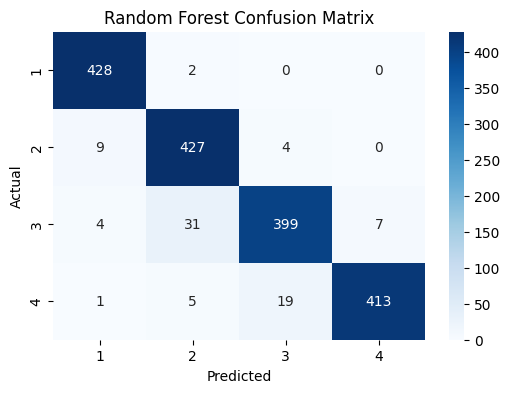

In [7]:
# Step 6 - Train Random Forest
# ------------------------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[1,2,3,4])
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


=== XGBoost Results ===
XGBoost Accuracy: 0.9605488850771869
              precision    recall  f1-score   support

           1       0.98      0.98      0.98       430
           2       0.91      0.97      0.94       440
           3       0.97      0.91      0.94       441
           4       0.98      0.98      0.98       438

    accuracy                           0.96      1749
   macro avg       0.96      0.96      0.96      1749
weighted avg       0.96      0.96      0.96      1749



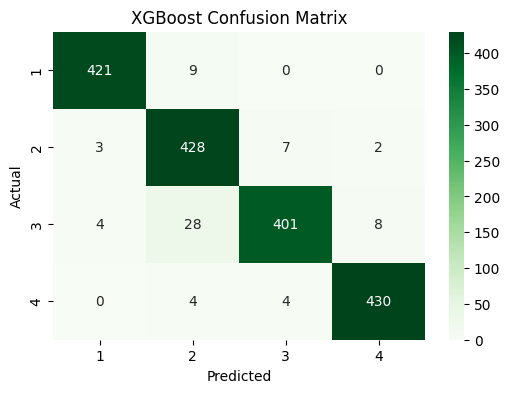

In [ ]:
# Step 7 - Train XGBoost 
# ------------------------------
y_train_res_xgb = y_train_res - 1  
y_test_xgb = y_test - 1            

xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb.fit(X_train_res, y_train_res_xgb)
y_pred_xgb = xgb.predict(X_test)              
y_pred_xgb_orig = y_pred_xgb + 1              

xgb_acc = accuracy_score(y_test, y_pred_xgb_orig)
print("\n=== XGBoost Results ===")
print("XGBoost Accuracy:", xgb_acc)
print(classification_report(y_test, y_pred_xgb_orig, labels=[1,2,3,4], zero_division=0))

cm_xgb = confusion_matrix(y_test, y_pred_xgb_orig, labels=[1,2,3,4])
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


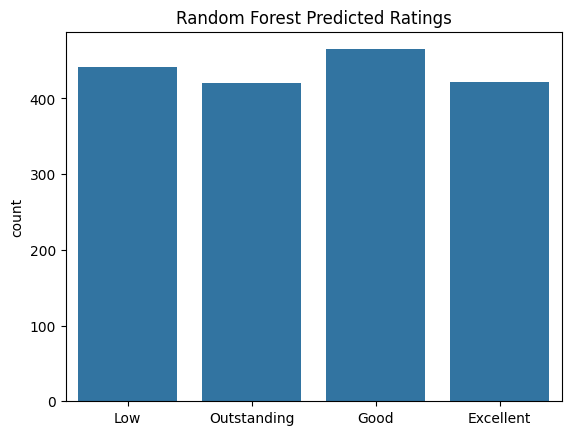

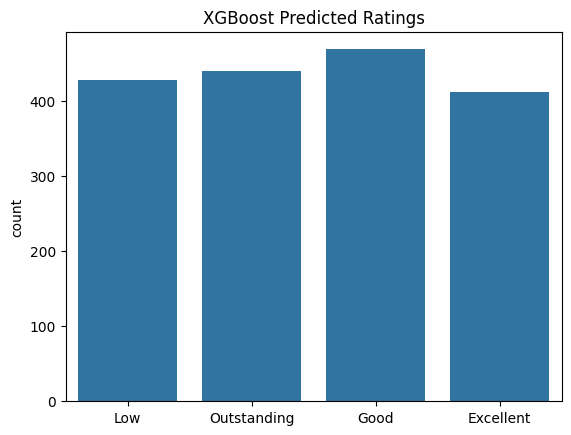

In [9]:
# Step 8 - Quick prediction distribution plots (readable labels)
# ------------------------------
rating_map = {1:'Low', 2:'Good', 3:'Excellent', 4:'Outstanding'}
y_pred_rf_labels = [rating_map[i] for i in y_pred_rf]
y_pred_xgb_labels = [rating_map[i] for i in y_pred_xgb_orig]

plt.figure()
sns.countplot(x=y_pred_rf_labels)
plt.title("Random Forest Predicted Ratings")
plt.show()

plt.figure()
sns.countplot(x=y_pred_xgb_labels)
plt.title("XGBoost Predicted Ratings")
plt.show()


In [10]:
# Step 9 - Model comparison metrics table
# ------------------------------
rf_prec = precision_score(y_test, y_pred_rf, average=None, labels=[1,2,3,4], zero_division=0)
rf_rec  = recall_score(y_test, y_pred_rf,  average=None, labels=[1,2,3,4], zero_division=0)
rf_f1   = f1_score(y_test, y_pred_rf,      average=None, labels=[1,2,3,4], zero_division=0)
rf_acc  = accuracy_score(y_test, y_pred_rf)

xgb_prec = precision_score(y_test, y_pred_xgb_orig, average=None, labels=[1,2,3,4], zero_division=0)
xgb_rec  = recall_score(y_test, y_pred_xgb_orig,  average=None, labels=[1,2,3,4], zero_division=0)
xgb_f1   = f1_score(y_test, y_pred_xgb_orig,      average=None, labels=[1,2,3,4], zero_division=0)
xgb_acc  = accuracy_score(y_test, y_pred_xgb_orig)

ratings = ["Low", "Good", "Excellent", "Outstanding"]

comparison_clean = pd.DataFrame({
    "Rating": ratings + ["Overall Accuracy"],
    "Random Forest (Precision)": list(rf_prec) + [rf_acc],
    "Random Forest (Recall)": list(rf_rec) + [rf_acc],
    "Random Forest (F1-score)": list(rf_f1) + [rf_acc],
    "XGBoost (Precision)": list(xgb_prec) + [xgb_acc],
    "XGBoost (Recall)": list(xgb_rec) + [xgb_acc],
    "XGBoost (F1-score)": list(xgb_f1) + [xgb_acc]
})

print("\n=== Model comparison ===")
print(comparison_clean)



=== Model comparison ===
             Rating  Random Forest (Precision)  Random Forest (Recall)  \
0               Low                   0.968326                0.995349   
1              Good                   0.918280                0.970455   
2         Excellent                   0.945498                0.904762   
3       Outstanding                   0.983333                0.942922   
4  Overall Accuracy                   0.953116                0.953116   

   Random Forest (F1-score)  XGBoost (Precision)  XGBoost (Recall)  \
0                  0.981651             0.983645          0.979070   
1                  0.943646             0.912580          0.972727   
2                  0.924681             0.973301          0.909297   
3                  0.962704             0.977273          0.981735   
4                  0.953116             0.960549          0.960549   

   XGBoost (F1-score)  
0            0.981352  
1            0.941694  
2            0.940211  
3           

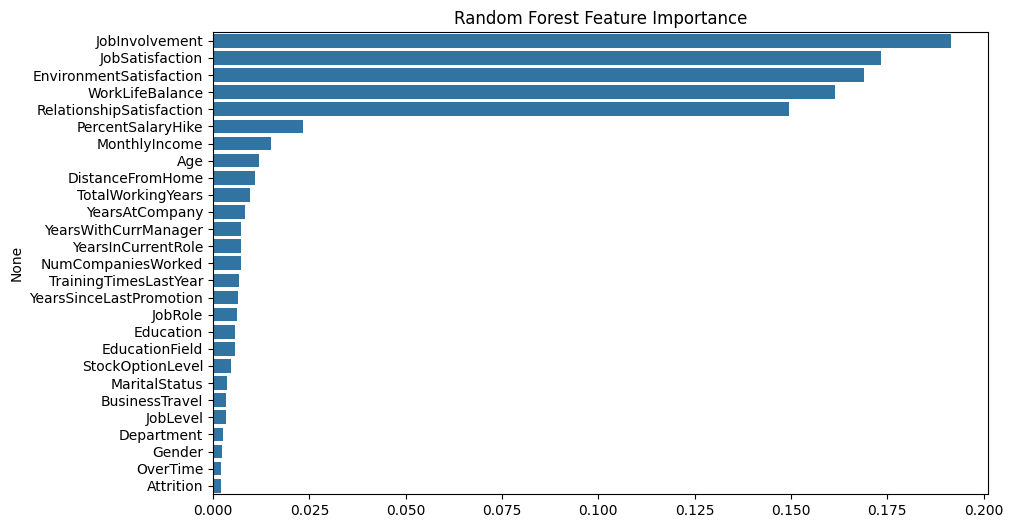

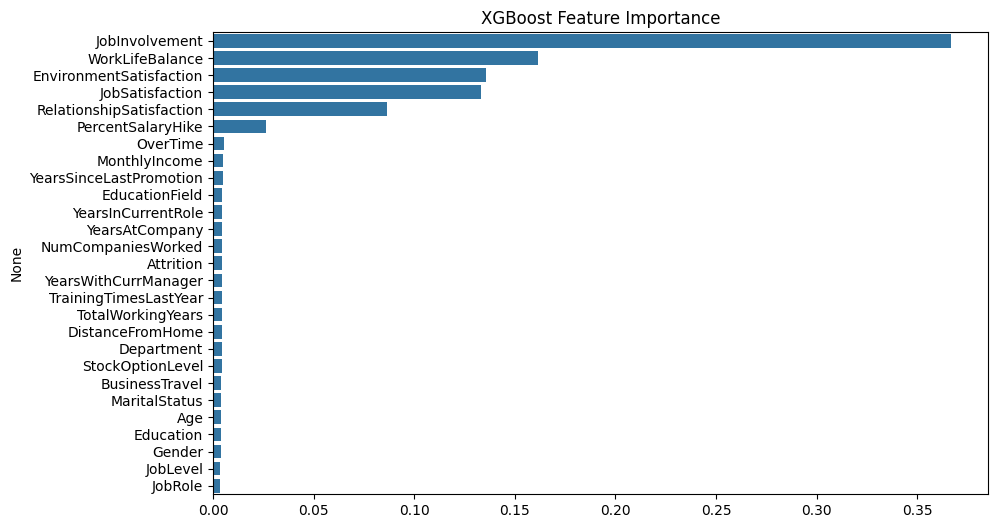

In [11]:
# Step 10 - Feature importances
# ------------------------------
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=rf_importances.values, y=rf_importances.index)
plt.title("Random Forest Feature Importance")
plt.show()

xgb_importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=xgb_importances.values, y=xgb_importances.index)
plt.title("XGBoost Feature Importance")
plt.show()


In [ ]:
# Step 11 - Hyperparameter tuning (GridSearch for RF and XGB)
# ------------------------------
print("\nRunning GridSearch for Random Forest (this may take a while)...")
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
rf_grid.fit(X_train_res, y_train_res)
best_rf = rf_grid.best_estimator_
print("Best RF params:", rf_grid.best_params_, "Best RF CV accuracy:", rf_grid.best_score_)

print("\nRunning GridSearch for XGBoost (this may take a while)...")
xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]
}

xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
                        xgb_param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_res, y_train_res - 1)   
best_xgb = xgb_grid.best_estimator_
print("Best XGB params:", xgb_grid.best_params_, "Best XGB CV accuracy:", xgb_grid.best_score_)



Running GridSearch for Random Forest (this may take a while)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100} Best RF CV accuracy: 0.94739066822327

Running GridSearch for XGBoost (this may take a while)...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1} Best XGB CV accuracy: 0.9611456721298618


In [ ]:
# Step 12 - Evaluate tuned models on test
# ------------------------------
rf_test_acc = accuracy_score(y_test, best_rf.predict(X_test))
xgb_test_preds = best_xgb.predict(X_test) + 1   
xgb_test_acc = accuracy_score(y_test, xgb_test_preds)

print("\nRandom Forest Test Accuracy:", rf_test_acc)
print("XGBoost Test Accuracy:", xgb_test_acc)

# Choose final model
if rf_test_acc >= xgb_test_acc:
    final_model = best_rf
    final_name = "Random Forest"
    needs_label_shift = False
else:
    final_model = best_xgb
    final_name = "XGBoost"
    needs_label_shift = True   

print(f"\n✅ Final Best Model Selected: {final_name}")
final_acc = max(rf_test_acc, xgb_test_acc)
print(f"Accuracy on Test Data: {final_acc:.4f}")



Random Forest Test Accuracy: 0.9548313321898227
XGBoost Test Accuracy: 0.9679817038307604

✅ Final Best Model Selected: XGBoost
Accuracy on Test Data: 0.9680


In [ ]:
# Step 13 - Save final model + metadata + encoders + features
# ------------------------------
joblib.dump(final_model, "best_model.pkl")
joblib.dump({"model_name": final_name, "needs_label_shift": needs_label_shift}, "model_metadata.pkl")

print("Saved best_model.pkl and model_metadata.pkl")



Saved best_model.pkl and model_metadata.pkl
